In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [25]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

In [26]:
dpicm_cm = pd.read_csv("dpicm_cm.csv")
icd_one = pd.read_csv("icd_one.csv")
icd_two = pd.read_csv("icd_two.csv")
icd_three = pd.read_csv("icd_three.csv")
icd_full = pd.read_csv("icd_full.csv")

In [4]:
icd_one.head()

,FIRST_ICD9_DIAGNOSIS,FIRST_ITEMID2,CATS,FIRST_NUMBER,LAST_ITEMID2,LAST_CATS,LAST_NUMBER,ICUFIRSTCAREUNIT,ICULASTCAREUNIT,ICUFIRSTWARDID,...,ICU_LOS,SAMECARE,SAMEWARD,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,LENGTHOFSTAY_DAYS
0,9678,69,1,0.0,69,1,0.0,1,1,1,...,1.1438,1,1,1,1,1,1,1,1,1
1,2252,226381,4,0.0,226228,1,0.0,2,2,2,...,1.2641,1,1,2,2,1,1,2,2,6
2,2252,226381,4,0.0,226228,1,0.0,3,3,3,...,1.1862,1,1,2,2,1,1,2,2,6
3,41041,159,2,0.0,27,9,0.0,4,4,4,...,0.5124,1,1,1,3,2,1,3,2,2
4,41071,781,1,51.0,43,3,0.0,4,4,4,...,3.5466,1,1,1,1,1,1,4,2,3


Removing sameward, samecare, and last number from consideration due to feature importance

In [27]:
icd_one.columns

Index(['FIRST_ICD9_DIAGNOSIS', 'FIRST_ITEMID2', 'CATS', 'FIRST_NUMBER',
       'LAST_ITEMID2', 'LAST_CATS', 'LAST_NUMBER', 'ICUFIRSTCAREUNIT',
       'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID', 'ICU_LOS',
       'SAMECARE', 'SAMEWARD', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY_DAYS'],
      dtype='object')

In [28]:
icd_one = icd_one[['FIRST_ICD9_DIAGNOSIS', 'FIRST_ITEMID2', 'CATS', 'FIRST_NUMBER',
       'LAST_ITEMID2', 'LAST_CATS', 'ICUFIRSTCAREUNIT',
       'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID', 'ICU_LOS',
       'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY_DAYS']]

In [29]:
icd_two = icd_two[['SECOND_ICD9_DIAGNOSIS', 'FIRST_ITEMID2', 'CATS', 'FIRST_NUMBER',
       'LAST_ITEMID2', 'LAST_CATS', 'ICUFIRSTCAREUNIT',
       'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID', 'ICU_LOS',
       'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY_DAYS']]

In [30]:
icd_three = icd_three[['THIRD_ICD9_DIAGNOSIS', 'FIRST_ITEMID2', 'CATS', 'FIRST_NUMBER',
       'LAST_ITEMID2', 'LAST_CATS', 'ICUFIRSTCAREUNIT',
       'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID', 'ICU_LOS',
       'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY_DAYS']]

In [31]:
icd_full = icd_full[['ICD9_DIAGNOSIS', 'FIRST_ITEMID2', 'CATS', 'FIRST_NUMBER',
       'LAST_ITEMID2', 'LAST_CATS', 'ICUFIRSTCAREUNIT',
       'ICULASTCAREUNIT', 'ICUFIRSTWARDID', 'ICULASTWARDID', 'ICU_LOS',
       'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'GENDER', 'LENGTHOFSTAY_DAYS']]

## Predicting Some ICD9 Codes Better than Others?

In [32]:
def forest_set(o_data, ts, icd9):

    if icd9 == 1: 
        icd_col = 'FIRST_ICD9_DIAGNOSIS'
    elif icd9 == 2: 
        icd_col = 'SECOND_ICD9_DIAGNOSIS'
    elif icd9 == 3:  
        icd_col = 'THIRD_ICD9_DIAGNOSIS'
    else: 
        icd_col = 'ICD9_DIAGNOSIS'
        
    otrain,otest = train_test_split(o_data, test_size=ts)
    rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
    rf_model.fit(otrain.ix[:,1:],otrain[icd_col])
    predicted_labels = rf_model.predict(otest.ix[:,1:])
    
    otest['predicted_rf_tree'] = predicted_labels
    accuracy = accuracy_score(otest[icd_col], predicted_labels)
    
    acc_by_code = {}
    for each_icd in otest[icd_col].unique():
        otest_bit = otest[(otest[icd_col] == each_icd)]
        accuracy_set = accuracy_score(otest_bit[icd_col], otest_bit['predicted_rf_tree'])
        acc_by_code[each_icd] = accuracy_set
        
    return((accuracy, acc_by_code))

In [33]:
def viz_acc_icd(acc_tup, file_name):
    objects = []
    performance = []
    for each_key in acc_tup[1]:
        if acc_tup[1][each_key] > 0:
            objects.append(each_key)
            performance.append(acc_tup[1][each_key])
    threshold = acc_tup[0]
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, performance, align='center', alpha=0.5, color=(254/255, 168/255, 182/255))
    #plt.xticks(y_pos, objects, rotation=90)
    #[0., len(objects)], 
    plt.axhline(threshold, color="gray")
    plt.ylim(0, 1) 
    plt.ylabel('Accuracy')
    plt.xlabel('ICD-9 Code')
    plt.title('Accuracy Across ICD-9 Codes')
    plt.savefig(file_name)
    plt.close()
    #plt.show()

In [34]:
def which_codes(code_dict):
    over_ninety = {}
    for each_code in code_dict: 
        if code_dict[each_code] > .90: 
            over_ninety[each_code] = code_dict[each_code]
    onine = pd.Series(over_ninety).to_frame()
    onine.columns = ['Accuracy']
    return(onine)

In [36]:
return_acc_one = forest_set(icd_one, 0.3, 1)
viz_acc_icd(return_acc_one, 'acc_one_test.png')

1778

In [37]:
ret = which_codes(return_acc_one[1])
print(len(ret))
ret.head()

182


,Accuracy
2798,0.913043
40301,0.939781
25061,0.937063
82322,1.000000
V561,1.000000


In [38]:
len(return_acc_one[1])

1810

In [39]:
return_acc_two = forest_set(icd_two, 0.3, 2)
viz_acc_icd(return_acc_two, 'acc_two_test.png')

In [40]:
len(return_acc_two[1])

1586

In [41]:
ret2 = which_codes(return_acc_two[1])
print(len(ret2))
ret2.head()

176


,Accuracy
51902,1.000000
40301,0.972603
78904,1.000000
1973,1.000000
4471,1.000000


In [42]:
return_acc_three = forest_set(icd_three, 0.3, 3)
viz_acc_icd(return_acc_three, 'acc_three_test.png')

In [43]:
len(return_acc_three[1])

1851

In [44]:
ret3 = which_codes(return_acc_three[1])
print(len(ret3))
ret3.head()

221


,Accuracy
2554,0.902439
5846,1.000000
57142,1.000000
30481,1.000000
78901,1.000000


In [53]:
# pull out index on each
# merge
# count matches

ret['ICD'] = ret.index
ret['NUM'] = 1
ret2['ICD'] = ret2.index
ret2['NUM'] = 2
ret3['ICD'] = ret3.index
ret3['NUM'] = 10

In [58]:
print(len(ret))
print(len(ret2))
print(len(ret3))

182
176
221


In [54]:
all_ret = ret.merge(ret2, on='ICD', how='outer')
all_ret = all_ret.merge(ret3, on='ICD', how='outer')

In [55]:
all_ret.head()

,Accuracy_x,ICD,NUM_x,Accuracy_y,NUM_y,Accuracy,NUM
0,0.913043,2798,1.0,NaN,NaN,NaN,NaN
1,0.939781,40301,1.0,0.972603,2.0,0.908333,10.0
2,0.937063,25061,1.0,0.954955,2.0,NaN,NaN
3,1.000000,82322,1.0,NaN,NaN,NaN,NaN
4,1.000000,V561,1.0,NaN,NaN,NaN,NaN


In [56]:
all_ret['sumsum'] = all_ret[['NUM_x', 'NUM_y', 'NUM']].sum(axis=1)
all_ret.head()

,Accuracy_x,ICD,NUM_x,Accuracy_y,NUM_y,Accuracy,NUM,sumsum
0,0.913043,2798,1.0,NaN,NaN,NaN,NaN,1.0
1,0.939781,40301,1.0,0.972603,2.0,0.908333,10.0,13.0
2,0.937063,25061,1.0,0.954955,2.0,NaN,NaN,3.0
3,1.000000,82322,1.0,NaN,NaN,NaN,NaN,1.0
4,1.000000,V561,1.0,NaN,NaN,NaN,NaN,1.0


In [57]:
all_ret['sumsum'].value_counts()

10.0    189
1.0     153
2.0     142
12.0     17
3.0      14
11.0     12
13.0      3
Name: sumsum, dtype: int64

In [67]:
shared = all_ret[(all_ret.sumsum == 3) | (all_ret.sumsum == 11) | (all_ret.sumsum == 12) | (all_ret.sumsum == 13)]
len(shared)

46

In [69]:
descriptors = shared.merge(desc, left_on = 'ICD', right_on = 'ICD9_CODE', how='left')
descriptors.head()
len(descriptors)

46

In [72]:
for each in descriptors['LONG_TITLE']: 
    print(each)

Hypertensive chronic kidney disease, malignant, with chronic kidney disease stage V or end stage renal disease
Diabetes with neurological manifestations, type I [juvenile type], not stated as uncontrolled
Severe pre-eclampsia, delivered, with or without mention of antepartum condition
Pneumonia due to other specified bacteria
Atrophic gastritis, with hemorrhage
Other adrenal hypofunction
Leukocytosis, unspecified
Abdominal pain, other specified site
Influenza due to identified avian influenza virus with pneumonia
Stenosis of pulmonary valve, congenital
Zygomycosis [Phycomycosis or Mucormycosis]
Pyogenic arthritis, pelvic region and thigh
Inflammatory conditions of jaw
Other preterm infants, 1,750-1,999 grams
Malignant neoplasm of splenic flexure
Other specified disorders of pancreatic internal secretion
nan
Patent ductus arteriosus
Miliary tuberculosis, unspecified, tubercle bacilli not found (in sputum) by microscopy, but found by bacterial culture
Electrolyte and fluid disorders not 

In [25]:
ret = ret.sort_values(by='Accuracy', ascending=False)
ret['Accuracy'].describe()

count    183.000000
mean       0.997908
std        0.011792
min        0.902439
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Accuracy, dtype: float64

In [24]:
ret2 = ret2.sort_values(by='Accuracy', ascending=False)
ret2['Accuracy'].describe()

count    172.000000
mean       0.996533
std        0.015208
min        0.909091
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Accuracy, dtype: float64

In [26]:
ret3 = ret3.sort_values(by='Accuracy', ascending=False)
ret3['Accuracy'].describe()

count    204.000000
mean       0.997606
std        0.013946
min        0.900901
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Accuracy, dtype: float64

## How many are in the ALL top 10%

In [31]:
ALL = ['9678','9693','E9502','E9503','3488','29620','4019','2252','3485',
 '78039','4241','2720','2724','V4581','V4579','V1582','41041','41401','53081']

In [32]:
one_in_ten = {}
for each_key in return_acc_one[1]:
    if each_key in ALL: 
        one_in_ten[each_key] = return_acc_one[1][each_key]
print(one_in_ten)

{'41401': 0.5894621295279913, '78039': 0.3888888888888889, '4019': 0.5675675675675675, '41041': 0.18681318681318682, '4241': 0.22459893048128343, '3488': 0.0, '2252': 0.2, '9678': 0.2857142857142857, '9693': 0.0, '53081': 0.7}


In [33]:
two_in_ten = {}
for each_key in return_acc_two[1]:
    if each_key in ALL: 
        two_in_ten[each_key] = return_acc_two[1][each_key]
print(two_in_ten)

{'3485': 0.22115384615384615, '78039': 0.5, '41401': 0.3569553805774278, '4019': 0.1032258064516129, '4241': 0.3902439024390244, '53081': 0.3125, '41041': 0.4117647058823529, '2720': 0.15384615384615385, '29620': 0.0, '2724': 0.44, '3488': 0.0, 'V4581': 0.0, '9693': 0.0, 'E9503': 0.0}


In [34]:
three_in_ten = {}
for each_key in return_acc_three[1]:
    if each_key in ALL: 
        three_in_ten[each_key] = return_acc_three[1][each_key]
print(three_in_ten)

{'4019': 0.3452914798206278, '41401': 0.33226837060702874, '78039': 0.5300546448087432, 'V4581': 0.3, '3485': 0.28169014084507044, '2720': 0.23148148148148148, '53081': 0.4423076923076923, '4241': 0.3380281690140845, '2724': 0.4583333333333333, 'E9503': 0.42857142857142855, '41041': 0.5454545454545454, '29620': 0.6, '9693': 0.0, 'V1582': 0.0, '3488': 0.3333333333333333, 'E9502': 0.0, '2252': 0.0}


In [35]:
o = ['9678',
 '2252',
 '41041',
 '41071',
 '99604',
 '99674',
 '3453',
 '0389',
 '42789',
 '41401']

In [36]:
t = ['9693',
 '3485',
 '41401',
 '25011',
 '4271',
 '4160',
 '20190',
 '4928',
 '4280',
 '42822',
 '4111',
 '99811',
 '0389',
 '5722',
 '03810',
 '78559',
 '3453',
 'E9102',
 '5849']

In [37]:
th = ['E9502',
 '78039',
 '53081',
 '41401',
 '4280',
 '4111',
 '515',
 '49390',
 '4254',
 '4263',
 '496',
 '41511',
 '99592',
 '2867',
 '5849']

In [38]:
one_in_ten = {}
for each_key in return_acc_one[1]:
    if each_key in o: 
        one_in_ten[each_key] = return_acc_one[1][each_key]
print(one_in_ten)

{'0389': 0.6208100558659218, '41401': 0.5894621295279913, '41071': 0.3774193548387097, '42789': 0.39436619718309857, '41041': 0.18681318681318682, '3453': 0.3275862068965517, '99674': 0.2876712328767123, '99604': 0.5833333333333334, '2252': 0.2, '9678': 0.2857142857142857}


In [39]:
two_in_ten = {}
for each_key in return_acc_two[1]:
    if each_key in t: 
        two_in_ten[each_key] = return_acc_two[1][each_key]
print(two_in_ten)

{'3485': 0.22115384615384615, '4928': 0.21739130434782608, '5849': 0.5679886685552408, '42822': 0.45652173913043476, '41401': 0.3569553805774278, '25011': 0.8666666666666667, '4280': 0.5100864553314121, '4111': 0.4222972972972973, '4271': 0.27380952380952384, '99811': 0.29577464788732394, '78559': 0.24096385542168675, '0389': 0.47580645161290325, '5722': 0.4411764705882353, '03810': 0.30434782608695654, '3453': 0.35294117647058826, '4160': 0.5806451612903226, '9693': 0.0, '20190': 0.75}


In [40]:
three_in_ten = {}
for each_key in return_acc_three[1]:
    if each_key in th: 
        three_in_ten[each_key] = return_acc_three[1][each_key]
print(three_in_ten)

{'4280': 0.603448275862069, '4254': 0.5774647887323944, '5849': 0.5408525754884547, '41401': 0.33226837060702874, '496': 0.43902439024390244, '78039': 0.5300546448087432, '49390': 0.3939393939393939, '515': 0.45, '99592': 0.5478927203065134, '53081': 0.4423076923076923, '4111': 0.34579439252336447, '2867': 0.6363636363636364, '41511': 0.0, '4263': 0.0, 'E9502': 0.0}


## Predicting First 3 Digits 

In [21]:
def forest_model(o_data, ts, icd9):

    if icd9 == 1: 
        icd_col = 'FIRST_ICD9_DIAGNOSIS'
    elif icd9 == 2: 
        icd_col = 'SECOND_ICD9_DIAGNOSIS'
    elif icd9 == 3:  
        icd_col = 'THIRD_ICD9_DIAGNOSIS'
    elif icd9 == 4: 
        icd_col = 'FIRSTDIGITS'
    else: 
        icd_col = 'ICD9_DIAGNOSIS'
         
    otrain,otest = train_test_split(o_data, test_size=ts)
    rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
    rf_model.fit(otrain.ix[:,1:],otrain[icd_col])
    predicted_labels = rf_model.predict(otest.ix[:,1:])
    
    otest['rf_predicted'] = predicted_labels
    accuracy = accuracy_score(otest[icd_col], predicted_labels)
    
    return((accuracy, rf_model))

In [35]:
testing1r = forest_model(icd_one, 0.3, 1)
testing1r[0]

0.48445013318573354

In [23]:
testing2r = forest_model(icd_two, 0.3, 2)
testing2r[0]

0.45229007633587787

In [24]:
testing3r = forest_model(icd_three, 0.3, 3)
testing3r[0]

0.4474418929294339

In [45]:
icd_one['FIRSTDIGITS'] = icd_one['FIRST_ICD9_DIAGNOSIS'].str[:3]
testing = forest_model(icd_one, 0.3, 4)

In [48]:
#icd_one.head()

In [46]:
testing[0]

0.4792610786314733

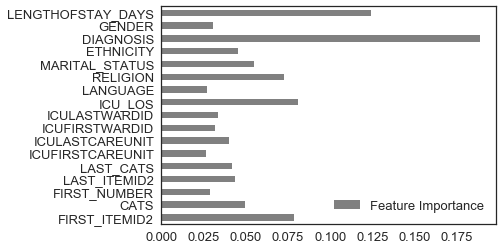

In [50]:
fi = testing[1].feature_importances_

#feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':fi},
            index=icd_one.columns[1:-1]).plot(kind='barh', color="gray")

In [51]:
icd_two['FIRSTDIGITS'] = icd_two['SECOND_ICD9_DIAGNOSIS'].str[:3]
testing2 = forest_model(icd_two, 0.3, 4)

In [52]:
testing2[0]

0.4371616932685635

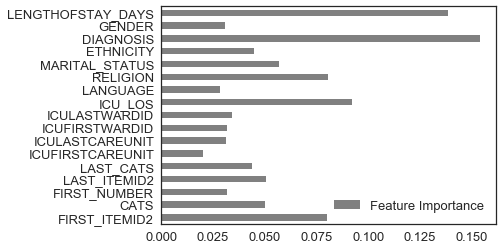

In [53]:
fi2 = testing2[1].feature_importances_

#feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':fi2},
            index=icd_two.columns[1:-1]).plot(kind='barh', color="gray")

In [54]:
icd_three['FIRSTDIGITS'] = icd_three['THIRD_ICD9_DIAGNOSIS'].str[:3]
testing3 = forest_model(icd_three, 0.3, 4)

In [55]:
testing3[0]

0.46551964821665387

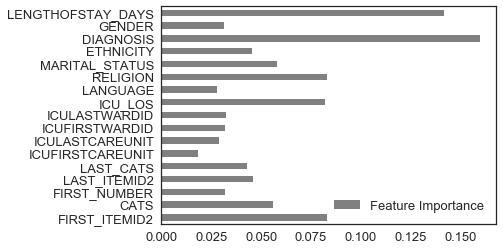

In [56]:
fi3 = testing3[1].feature_importances_

#feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':fi3},
            index=icd_three.columns[1:-1]).plot(kind='barh', color="gray")

## Predicting Knowing Other ICD9?

## Matching ICD9 Code to Description

In [4]:
desc = pd.read_csv('D_ICD_DIAGNOSES.csv')

In [5]:
desc.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [20]:
desc[(desc.ICD9_CODE == '3488')]

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE


In [4]:
match1 = ['9678','9693','E9502','E9503','3488','29620','4019','2252','3485',
 '78039','4241','2720','2724','V4581','V4579','V1582','41041','41401','53081']

In [9]:
for each_code in match1: 
    print(desc[(desc['ICD9_CODE'] == each_code)])

       ROW_ID ICD9_CODE               SHORT_TITLE  \
13908   11344      9678  Pois-sedative/hypnot NEC   

                                       LONG_TITLE  
13908  Poisoning by other sedatives and hypnotics  
       ROW_ID ICD9_CODE               SHORT_TITLE  \
12784   11553      9693  Poison-antipsychotic NEC   

                                              LONG_TITLE  
12784  Poisoning by other antipsychotics, neuroleptic...  
       ROW_ID ICD9_CODE            SHORT_TITLE  \
11218    9947     E9502  Poison-sedat/hypnotic   

                                              LONG_TITLE  
11218  Suicide and self-inflicted poisoning by other ...  
       ROW_ID ICD9_CODE              SHORT_TITLE  \
11219    9948     E9503  Poison-psychotropic agt   

                                              LONG_TITLE  
11219  Suicide and self-inflicted poisoning by tranqu...  
Empty DataFrame
Columns: [ROW_ID, ICD9_CODE, SHORT_TITLE, LONG_TITLE]
Index: []
      ROW_ID ICD9_CODE               SHORT

In [6]:
match2 = ['9678',
 '2252',
 '41041',
 '41071',
 '99604',
 '99674',
 '3453',
 '0389',
 '42789',
 '41401']

In [8]:
for each_code in match2: 
    print(desc[(desc['ICD9_CODE'] == each_code)])

       ROW_ID ICD9_CODE               SHORT_TITLE  \
13908   11344      9678  Pois-sedative/hypnot NEC   

                                       LONG_TITLE  
13908  Poisoning by other sedatives and hypnotics  
      ROW_ID ICD9_CODE              SHORT_TITLE  \
2779    2503      2252  Ben neo cerebr meninges   

                                LONG_TITLE  
2779  Benign neoplasm of cerebral meninges  
      ROW_ID ICD9_CODE              SHORT_TITLE  \
4347    4348     41041  AMI inferior wall, init   

                                             LONG_TITLE  
4347  Acute myocardial infarction of other inferior ...  
      ROW_ID ICD9_CODE               SHORT_TITLE  \
4356    4357     41071  Subendo infarct, initial   

                                             LONG_TITLE  
4356  Subendocardial infarction, initial episode of ...  
       ROW_ID ICD9_CODE               SHORT_TITLE  \
10312   11411     99604  Mch cmp autm mplnt dfbrl   

                                              LON

In [9]:
match3 = ['9693',
 '3485',
 '41401',
 '25011',
 '4271',
 '4160',
 '20190',
 '4928',
 '4280',
 '42822',
 '4111',
 '99811',
 '0389',
 '5722',
 '03810',
 '78559',
 '3453',
 'E9102',
 '5849']

In [10]:
for each_code in match3: 
    print(desc[(desc['ICD9_CODE'] == each_code)])

       ROW_ID ICD9_CODE               SHORT_TITLE  \
12784   11553      9693  Poison-antipsychotic NEC   

                                              LONG_TITLE  
12784  Poisoning by other antipsychotics, neuroleptic...  
      ROW_ID ICD9_CODE     SHORT_TITLE      LONG_TITLE
2800    2801      3485  Cerebral edema  Cerebral edema
      ROW_ID ICD9_CODE               SHORT_TITLE  \
4373    4374     41401  Crnry athrscl natve vssl   

                                             LONG_TITLE  
4373  Coronary atherosclerosis of native coronary ar...  
      ROW_ID ICD9_CODE              SHORT_TITLE  \
1593    1596     25011  DMI keto nt st uncntrld   

                                             LONG_TITLE  
1593  Diabetes with ketoacidosis, type I [juvenile t...  
      ROW_ID ICD9_CODE              SHORT_TITLE  \
4459    4460      4271  Parox ventric tachycard   

                              LONG_TITLE  
4459  Paroxysmal ventricular tachycardia  
      ROW_ID ICD9_CODE             S

In [11]:
match4 = ['E9502',
 '78039',
 '53081',
 '41401',
 '4280',
 '4111',
 '515',
 '49390',
 '4254',
 '4263',
 '496',
 '41511',
 '99592',
 '2867',
 '5849']

In [12]:
for each_code in match4: 
    print(desc[(desc['ICD9_CODE'] == each_code)])

       ROW_ID ICD9_CODE            SHORT_TITLE  \
11218    9947     E9502  Poison-sedat/hypnotic   

                                              LONG_TITLE  
11218  Suicide and self-inflicted poisoning by other ...  
      ROW_ID ICD9_CODE      SHORT_TITLE         LONG_TITLE
8967    8968     78039  Convulsions NEC  Other convulsions
      ROW_ID ICD9_CODE        SHORT_TITLE         LONG_TITLE
6009    6013     53081  Esophageal reflux  Esophageal reflux
      ROW_ID ICD9_CODE               SHORT_TITLE  \
4373    4374     41401  Crnry athrscl natve vssl   

                                             LONG_TITLE  
4373  Coronary atherosclerosis of native coronary ar...  
      ROW_ID ICD9_CODE SHORT_TITLE                             LONG_TITLE
4472    4473      4280     CHF NOS  Congestive heart failure, unspecified
      ROW_ID ICD9_CODE             SHORT_TITLE                      LONG_TITLE
4365    4366      4111  Intermed coronary synd  Intermediate coronary syndrome
      ROW_ID I